In [1]:
import plotnine
from plotnine import *
from m_kipoi.config import get_data_dir, setup_matplotlib
import json
from m_kipoi.exp.tlearn.tfdragonn import parse_log
from pathlib import Path
from snakemake.io import glob_wildcards
ddir = get_data_dir()
setup_matplotlib()

Using TensorFlow backend.


In [7]:
def load_results(glob_str=f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/valid/epoch-{{epoch}}.metrics.json"):
    def read_result(task, epoch, glob_str):
        fname = glob_str.format(task=task, epoch=epoch)
        return {"task": task, "epoch": int(epoch)+1, 
                **json.loads(Path(fname).read_text())}
    tasks, epochs,  = glob_wildcards(glob_str)
    return pd.DataFrame([read_result(task, epoch, glob_str) for task, epoch in zip(tasks, epochs)]).sort_values(['task', 'epoch'])

In [8]:
# Annotation
anno = pd.read_csv(f"{ddir}/raw/tlearn/metadata/anno.csv")

In [9]:
anno.head()

,task,Cell_Type
0,ENCSR000EMT,GM12878
1,ENCSR000EPC,K562
2,ENCSR452SPC,Brain
3,ENCSR714DIF,Mesendoderm
4,ENCSR917VCP,Thymus


In [10]:
encode_ids = anno.task.tolist()

## Test-set

In [11]:
# Pre-trained 
dftn = load_results(f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/test/epoch-{{epoch}}.metrics.json").rename(columns={"auprc": "auPRC"})

In [12]:
dfto = pd.concat([parse_log(f"{ddir}/processed/tlearn/models/random/test/{encode_id}/tfdragonn.log").assign(task=encode_id) 
                  for encode_id in encode_ids])

/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:62: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  ("weights_file", weights_file),
/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:65: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  dfo['best_epoch'] = dfo.iloc[dfo.auPRC.argmax()].epoch


In [13]:
# Merge Pre-trained + Random
dft = pd.concat([dftn[['auPRC', 'task']].merge(anno, on='task').assign(Model="Pre-trained"),
                 dfto.merge(anno, on='task')[['task', 'Cell_Type', 'auPRC']].assign(Model='Random')], sort=True)

In [14]:
dft

,Cell_Type,Model,auPRC,task
0,GM12878,Pre-trained,0.4058,ENCSR000EMT
1,Cardiac Mesendoderm,Pre-trained,0.4743,ENCSR000EMX
2,Jakart Clone E61,Pre-trained,0.4763,ENCSR000EOS
...,...,...,...,...
7,Cardiac Mesendoderm,Random,0.3540,ENCSR000EMX
8,Lung,Random,0.3900,ENCSR076YBB;ENCSR456K...
9,Common myeloid progen...,Random,0.4590,ENCSR122VUW;ENCSR191E...


In [15]:
# Organize
dft['Cell_Type_cat'] = pd.Categorical(dft['Cell_Type'], categories=dft.sort_values("Cell_Type", ascending=True).Cell_Type.unique(), ordered=True)
dft['Model'] = pd.Categorical(dft['Model'], categories=['Random', 'Pre-trained'], ordered=True)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplica

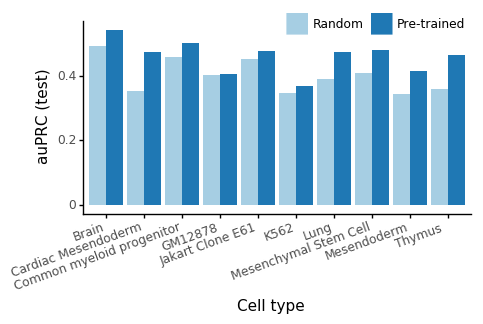

<ggplot: (-9223363300608181518)>

In [16]:
plotnine.options.figure_size = (5,2.5)
gplt = ggplot(aes(x='Cell_Type', y='auPRC', fill='Model'), data=dft) + \
    theme_classic() + \
    theme(axis_text_x=element_text(angle=20, hjust = 1)) + \
    theme(legend_title=element_blank(), 
          legend_box_margin=0,
          legend_direction='horizontal', legend_position=(0.71,0.87)) + \
    geom_bar(stat='identity', position="dodge") + \
    scale_fill_brewer("qual", 3) + \
    xlab("Cell type") + \
    ylab("auPRC (test)")
gplt

In [525]:
gplt.save("plots/fig3b.pdf", dpi=600)
gplt.save("plots/fig3b.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 5 x 2.5 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig3b.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: A

## Validation

In [17]:
# Pre-trained
dfvn = load_results(f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/valid/epoch-{{epoch}}.metrics.json").rename(columns={"auprc": "auPRC"})
dfvn = dfvn.merge((dfvn.groupby("task").epoch.max()-1).reset_index().rename(columns={"epoch": "best_epoch"}), on="task", how="left")

In [18]:
dfvo = pd.concat([parse_log(f"{ddir}/processed/tlearn/models/random/valid/{encode_id}/tfdragonn.log").assign(task=encode_id) 
                  for encode_id in encode_ids])

/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:62: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  ("weights_file", weights_file),
/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:65: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  dfo['best_epoch'] = dfo.iloc[dfo.auPRC.argmax()].epoch


In [19]:
# Merge pre-trained + random
dfv = pd.concat([dfvn[['auPRC', 'epoch', 'best_epoch', 'task']].merge(anno, on='task').assign(Model='Pre-trained'),
                 dfvo.merge(anno, on='task')[['auPRC', 'epoch', 'best_epoch', 'task', "Cell_Type"]].assign(Model='Random')])

In [20]:
# Organize
dfv['Model'] = pd.Categorical(dfv['Model'], categories=['Random', 'Pre-trained'], ordered=True)
dfv_best_epoch = dfv[['Model', 'Cell_Type', 'best_epoch']].drop_duplicates()

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


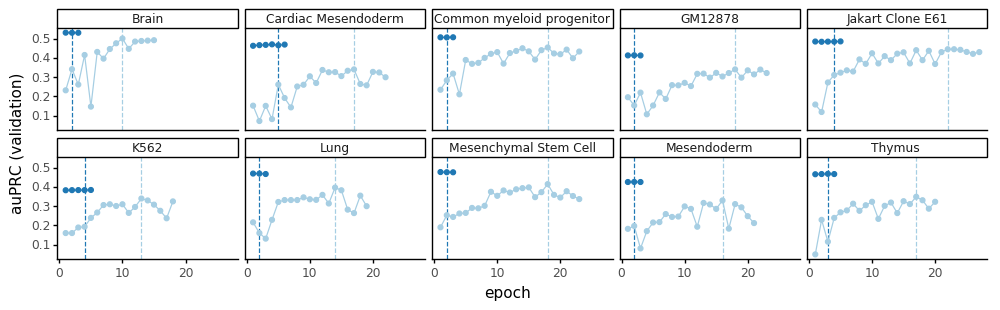

<ggplot: (-9223363300610047004)>

In [21]:
plotnine.options.figure_size = (12,3)
plt = ggplot(aes(x='epoch', y='auPRC', group='Model', color='Model'), data=dfv) + \
    geom_vline(aes(xintercept="best_epoch", color='Model'), dfv_best_epoch, linetype='dashed', alpha=1) + \
    geom_line() + \
    geom_point() + \
    facet_wrap('~Cell_Type', nrow=2) + \
    theme_classic() + \
    scale_color_brewer("qual", 3) + \
    theme(legend_position=(0.8, 0.3)) + \
    ylab("auPRC (validation)")
plt

In [22]:
dfv

,auPRC,epoch,best_epoch,task,Cell_Type,Model
0,0.4138,1,2,ENCSR000EMT,GM12878,Pre-trained
1,0.4146,2,2,ENCSR000EMT,GM12878,Pre-trained
2,0.4135,3,2,ENCSR000EMT,GM12878,Pre-trained
...,...,...,...,...,...,...
208,0.4440,21,18,ENCSR122VUW;ENCSR191E...,Common myeloid progen...,Random
209,0.3990,22,18,ENCSR122VUW;ENCSR191E...,Common myeloid progen...,Random
210,0.4340,23,18,ENCSR122VUW;ENCSR191E...,Common myeloid progen...,Random


In [23]:
dfv_total_epoch_stacked = dfv[['Cell_Type', 'Model']].groupby(['Cell_Type', 'Model']).size().unstack()
dfv_total_epoch_stacked.columns = ['Random', 'Pre-trained']
dfv_total_epoch_stacked['speedup'] = dfv_total_epoch_stacked['Random']/dfv_total_epoch_stacked['Pre-trained'] 
print(dfv_total_epoch_stacked.to_string())

                           Random  Pre-trained  speedup
Cell_Type                                              
Brain                          15            3   5.0000
Cardiac Mesendoderm            22            6   3.6667
Common myeloid progenitor      23            3   7.6667
GM12878                        23            3   7.6667
Jakart Clone E61               27            5   5.4000
K562                           18            5   3.6000
Lung                           19            3   6.3333
Mesenchymal Stem Cell          23            3   7.6667
Mesendoderm                    21            3   7.0000
Thymus                         20            4   5.0000


In [27]:
dfv_total_epoch_stacked.describe().head(2)

,Random,Pre-trained,speedup
count,10.0,10.0,10.0
mean,21.1,3.8,5.9


In [29]:
dfv_best_epoch_stacked = dfv_best_epoch.set_index(['Cell_Type', 'Model']).best_epoch.unstack()
dfv_best_epoch_stacked.columns = ['Random', 'Pre-trained']
dfv_best_epoch_stacked['speedup'] = dfv_best_epoch_stacked['Random']/dfv_best_epoch_stacked['Pre-trained'] 
print(dfv_best_epoch_stacked.to_string())

                           Random  Pre-trained  speedup
Cell_Type                                              
Brain                          10            2   5.0000
Cardiac Mesendoderm            17            5   3.4000
Common myeloid progenitor      18            2   9.0000
GM12878                        18            2   9.0000
Jakart Clone E61               22            4   5.5000
K562                           13            4   3.2500
Lung                           14            2   7.0000
Mesenchymal Stem Cell          18            2   9.0000
Mesendoderm                    16            2   8.0000
Thymus                         17            3   5.6667


In [30]:
dfv_best_epoch_stacked.describe().head(2)

,Random,Pre-trained,speedup
count,10.0,10.0,10.0000
mean,16.3,2.8,6.4817


In [31]:
plt.save("plots/fig3c.pdf", dpi=600)
plt.save("plots/fig3c.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 12 x 3 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig3c.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: At